In [1]:
!pip install piqa

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from piqa import SSIM

In [3]:
#Encoder
class Encoder(nn.Module):
    def __init__(self,X_dim,N,z_dim):
        super(Encoder, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss

# Decoder
class Decoder(nn.Module):
    def __init__(self,X_dim,N,z_dim):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self,N,z_dim):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))


In [4]:
dataset = dsets.MNIST(root='./data',
                      train=False,
                      transform=transforms.ToTensor(),
                      download=True)

n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val

train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=32,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=val_set,
                                          batch_size=120,
                                          shuffle=True)

print(len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 175376103.04it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40151042.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45272920.90it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22842360.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

17


In [5]:
def to_numpy(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [6]:
EPS = 1e-15
z_red_dims = 2
enc_1 = Encoder(784,1000,z_red_dims).cuda()
dec_1 = Decoder(784,1000,z_red_dims).cuda()
disc_1 = Discriminator(500,z_red_dims).cuda()

gen_lr = 0.0001
reg_lr = 0.00005

optim_dec_1 = torch.optim.Adam(dec_1.parameters(), lr=gen_lr)
optim_enc_1 = torch.optim.Adam(enc_1.parameters(), lr=gen_lr)
#regularizing optimizers
optim_enc_1_gen = torch.optim.Adam(enc_1.parameters(), lr=reg_lr)
optim_disc_1 = torch.optim.Adam(disc_1.parameters(), lr=reg_lr)


epochs = 100

recon_loss_train_bce = []
disc_loss_train_bce = []


data_iter = iter(test_loader)
cos = nn.CosineSimilarity()

# Start training
for epoch in range(1,epochs+1):

    if(epoch%10==0):
        print(F"{epoch} epochs completed")
    epoch_recon_loss = 0
    epoch_disc_loss = 0


    # Reset the data_iter
    for idx,(data,lables) in enumerate(train_loader):

        # Fetch the images and labels and convert them to variables
        images, labels = data,lables
        images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)

        #reconstruction loss
        dec_1.zero_grad()
        enc_1.zero_grad()
        dec_1.zero_grad()

        z_sample = enc_1(images)   #encode to z
        X_sample = dec_1(z_sample) #decode to X reconstruction
        recon_loss = F.binary_cross_entropy(X_sample+EPS,images+EPS)



        recon_loss.backward()
        optim_dec_1.step()
        optim_enc_1.step()

        epoch_recon_loss+=recon_loss.item()

        # Discriminator
        ## true prior is random normal (randn)
        ## this is constraining the Z-projection to be normal!
        enc_1.eval()
        z_real_gauss = Variable(torch.randn(images.size()[0], z_red_dims) * 5.).cuda()
        D_real_gauss = disc_1(z_real_gauss)

        z_fake_gauss = enc_1(images)
        D_fake_gauss = disc_1(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))

        D_loss.backward()
        optim_disc_1.step()

        epoch_disc_loss+=D_loss.item()

        # Generator
        enc_1.train()
        z_fake_gauss = enc_1(images)
        D_fake_gauss = disc_1(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))

        G_loss.backward()
        optim_enc_1_gen.step()

    recon_loss_train_bce.append(epoch_recon_loss/len(train_loader))
    disc_loss_train_bce.append(epoch_disc_loss/len(train_loader))

10 epochs completed
20 epochs completed
30 epochs completed
40 epochs completed
50 epochs completed
60 epochs completed
70 epochs completed
80 epochs completed
90 epochs completed
100 epochs completed


In [7]:
bce_encoder,bce_decoder,bce_recon_loss,bce_disc_loss=enc_1,dec_1,recon_loss_train_bce,disc_loss_train_bce

In [21]:
print(bce_recon_loss[-1])
print(bce_disc_loss[-1])

0.18671897345781327
0.6888023653030395


In [9]:
iter_test = iter(train_loader)
images, labels = next(iter_test)

show_img = dict()
for i in range(10):
    show_img[i] = images[(labels == i).nonzero(as_tuple=True)[0].tolist()[0]]

In [10]:
def show_genreated_img(x,decoder,encoder):
    encoder.eval()
    decoder.eval()
    fig, ax = plt.subplots(10, 2, figsize=(25,20))
    fig.tight_layout()
    for i in range(10):
        ax[i,0].imshow(x[i][0], cmap='gray')
        ax[i,0].title.set_text('Original Image of Digit '+str(i))
        image = Variable(x[i].view(x[i].size(0), -1).cuda())
        z_samples = encoder(image)
        X_samples = decoder(z_samples).reshape(28,28).cpu().detach().numpy()
        ax[i,1].imshow(X_samples, cmap='gray')
        ax[i,1].title.set_text('Generated Image of Digit '+str(i))
    fig.suptitle('Original vs Generated Image')
    plt.show()

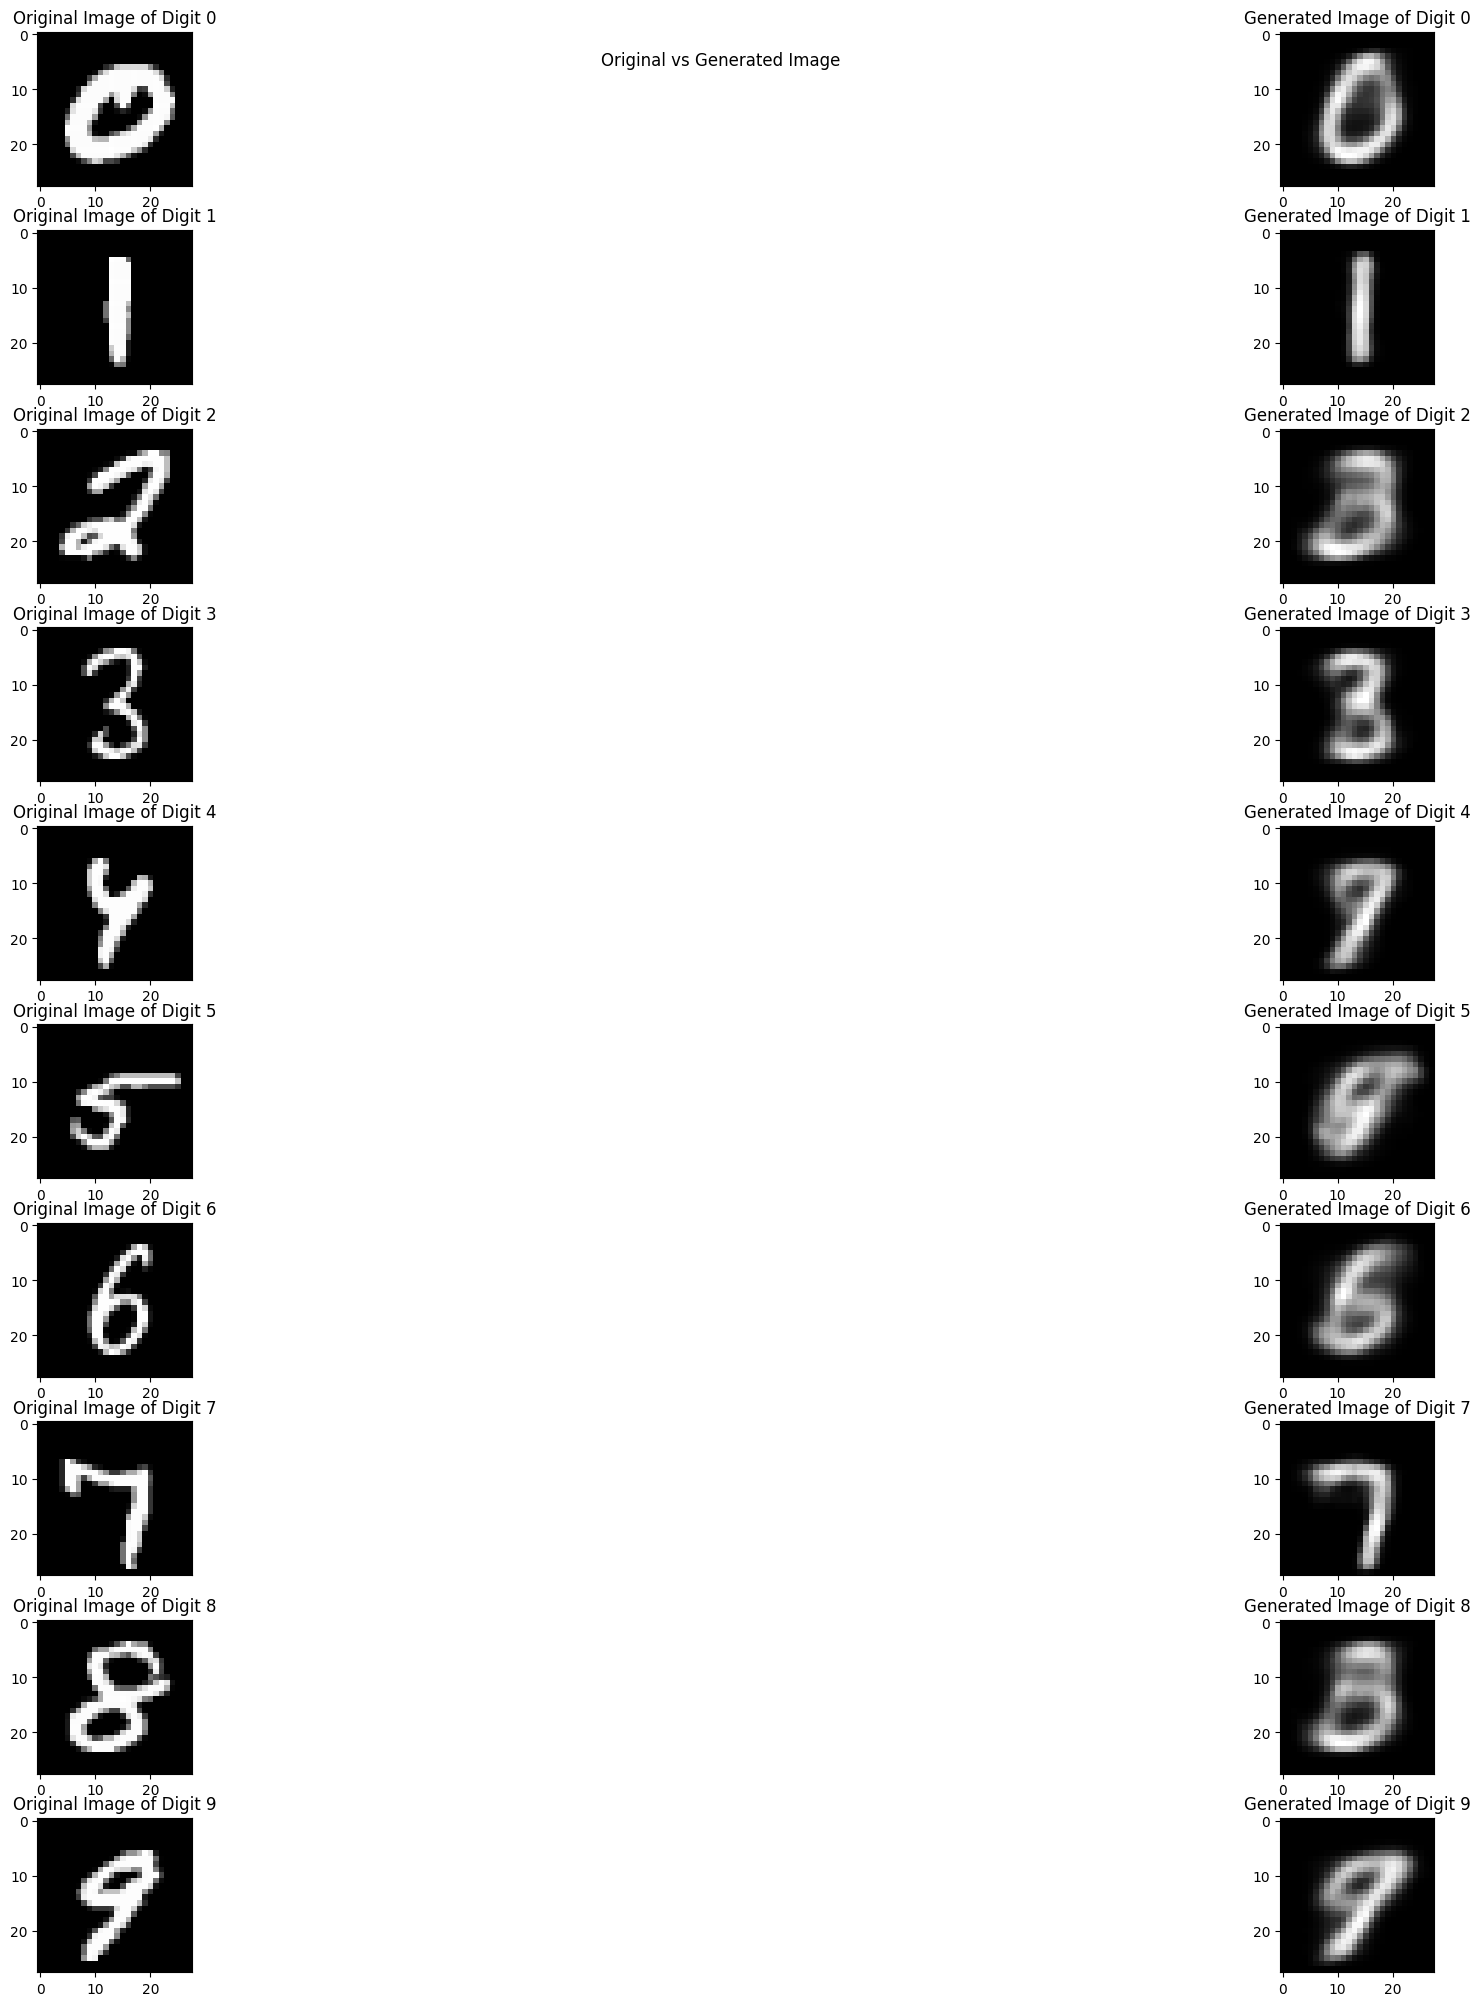

In [11]:
show_genreated_img(show_img,dec_1,enc_1)

In [12]:
EPS = 1e-15
z_red_dims = 2
enc_1 = Encoder(784,1000,z_red_dims).cuda()
dec_1 = Decoder(784,1000,z_red_dims).cuda()
disc_1 = Discriminator(500,z_red_dims).cuda()

gen_lr = 0.0001
reg_lr = 0.00005

optim_dec_1 = torch.optim.Adam(dec_1.parameters(), lr=gen_lr)
optim_enc_1 = torch.optim.Adam(enc_1.parameters(), lr=gen_lr)
#regularizing optimizers
optim_enc_1_gen = torch.optim.Adam(enc_1.parameters(), lr=reg_lr)
optim_disc_1 = torch.optim.Adam(disc_1.parameters(), lr=reg_lr)


epochs = 100

recon_loss_train_bce = []
disc_loss_train_bce = []


data_iter = iter(test_loader)
cos = nn.CosineSimilarity()

# Start training
for epoch in range(1,epochs+1):

    if(epoch%10==0):
        print(F"{epoch} epochs completed")
    epoch_recon_loss = 0
    epoch_disc_loss = 0


    # Reset the data_iter
    for idx,(data,lables) in enumerate(train_loader):

        # Fetch the images and labels and convert them to variables
        images, labels = data,lables
        images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)

        #reconstruction loss
        dec_1.zero_grad()
        enc_1.zero_grad()
        dec_1.zero_grad()

        z_sample = enc_1(images)   #encode to z
        X_sample = dec_1(z_sample) #decode to X reconstruction
        recon_loss = F.mse_loss(X_sample+EPS,images+EPS)



        recon_loss.backward()
        optim_dec_1.step()
        optim_enc_1.step()

        epoch_recon_loss+=recon_loss.item()

        # Discriminator
        ## true prior is random normal (randn)
        ## this is constraining the Z-projection to be normal!
        enc_1.eval()
        z_real_gauss = Variable(torch.randn(images.size()[0], z_red_dims) * 5.).cuda()
        D_real_gauss = disc_1(z_real_gauss)

        z_fake_gauss = enc_1(images)
        D_fake_gauss = disc_1(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))

        D_loss.backward()
        optim_disc_1.step()

        epoch_disc_loss+=D_loss.item()

        # Generator
        enc_1.train()
        z_fake_gauss = enc_1(images)
        D_fake_gauss = disc_1(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))

        G_loss.backward()
        optim_enc_1_gen.step()

    recon_loss_train_bce.append(epoch_recon_loss/len(train_loader))
    disc_loss_train_bce.append(epoch_disc_loss/len(train_loader))

10 epochs completed
20 epochs completed
30 epochs completed
40 epochs completed
50 epochs completed
60 epochs completed
70 epochs completed
80 epochs completed
90 epochs completed
100 epochs completed


In [13]:
mse_encoder,mse_decoder,mse_recon_loss,mse_disc_loss=enc_1,dec_1,recon_loss_train_bce,disc_loss_train_bce

In [22]:
print(mse_recon_loss[-1])
print(mse_disc_loss[-1])

0.042593452364206315
0.6596038084030151


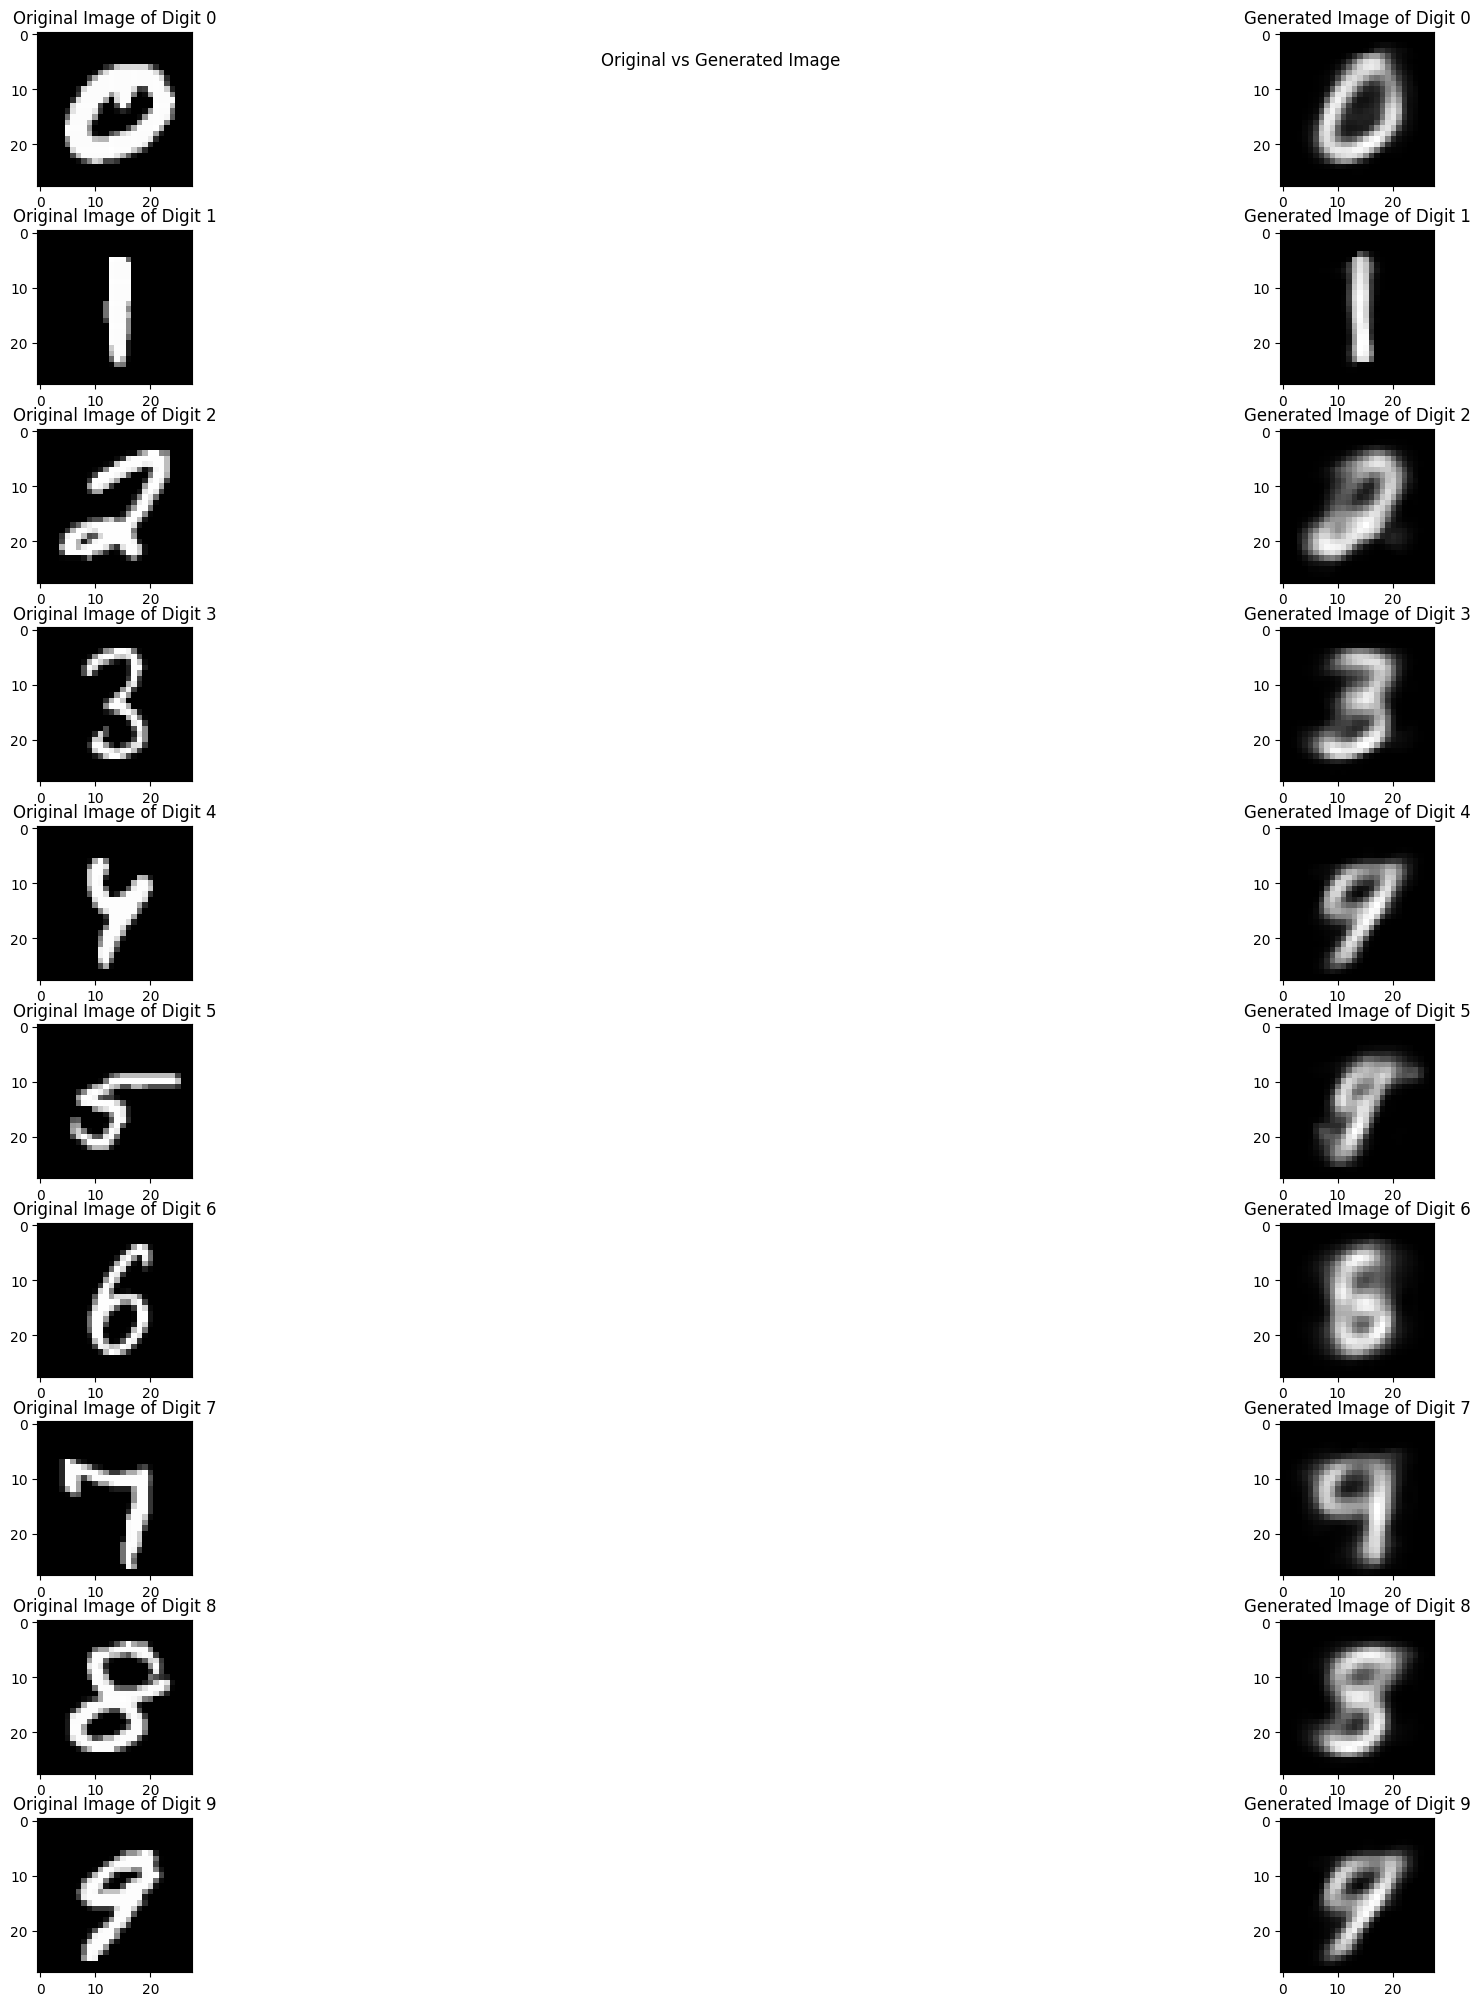

In [15]:
show_genreated_img(show_img,mse_decoder,mse_encoder)

In [16]:
EPS = 1e-15
z_red_dims = 2
enc_1 = Encoder(784,1000,z_red_dims).cuda()
dec_1 = Decoder(784,1000,z_red_dims).cuda()
disc_1 = Discriminator(500,z_red_dims).cuda()

gen_lr = 0.0001
reg_lr = 0.00005

optim_dec_1 = torch.optim.Adam(dec_1.parameters(), lr=gen_lr)
optim_enc_1 = torch.optim.Adam(enc_1.parameters(), lr=gen_lr)
#regularizing optimizers
optim_enc_1_gen = torch.optim.Adam(enc_1.parameters(), lr=reg_lr)
optim_disc_1 = torch.optim.Adam(disc_1.parameters(), lr=reg_lr)


epochs = 100
loss=SSIM(n_channels=1).cuda()

recon_loss_train_bce = []
disc_loss_train_bce = []


data_iter = iter(test_loader)
cos = nn.CosineSimilarity()

# Start training
for epoch in range(1,epochs+1):

    if(epoch%10==0):
        print(F"{epoch} epochs completed")
    epoch_recon_loss = 0
    epoch_disc_loss = 0


    # Reset the data_iter
    for idx,(data,lables) in enumerate(train_loader):

        # Fetch the images and labels and convert them to variables
        images, labels = data,lables
        images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)

        #reconstruction loss
        dec_1.zero_grad()
        enc_1.zero_grad()
        dec_1.zero_grad()

        z_sample = enc_1(images)   #encode to z
        X_sample = dec_1(z_sample) #decode to X reconstruction
        recon_loss =1- loss(torch.unsqueeze(X_sample+EPS, 1), torch.unsqueeze(images+EPS, 1))



        recon_loss.backward()
        optim_dec_1.step()
        optim_enc_1.step()

        epoch_recon_loss+=recon_loss.item()

        # Discriminator
        ## true prior is random normal (randn)
        ## this is constraining the Z-projection to be normal!
        enc_1.eval()
        z_real_gauss = Variable(torch.randn(images.size()[0], z_red_dims) * 5.).cuda()
        D_real_gauss = disc_1(z_real_gauss)

        z_fake_gauss = enc_1(images)
        D_fake_gauss = disc_1(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))

        D_loss.backward()
        optim_disc_1.step()

        epoch_disc_loss+=D_loss.item()

        # Generator
        enc_1.train()
        z_fake_gauss = enc_1(images)
        D_fake_gauss = disc_1(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))

        G_loss.backward()
        optim_enc_1_gen.step()

    recon_loss_train_bce.append(epoch_recon_loss/len(train_loader))
    disc_loss_train_bce.append(epoch_disc_loss/len(train_loader))

10 epochs completed
20 epochs completed
30 epochs completed
40 epochs completed
50 epochs completed
60 epochs completed
70 epochs completed
80 epochs completed
90 epochs completed
100 epochs completed


In [17]:
ssim_encoder,ssim_decoder,ssim_recon_loss,ssim_disc_loss=enc_1,dec_1,recon_loss_train_bce,disc_loss_train_bce

In [23]:
print(ssim_recon_loss[-1])
print(ssim_disc_loss[-1])

0.2781109049320221
0.7695398344993591


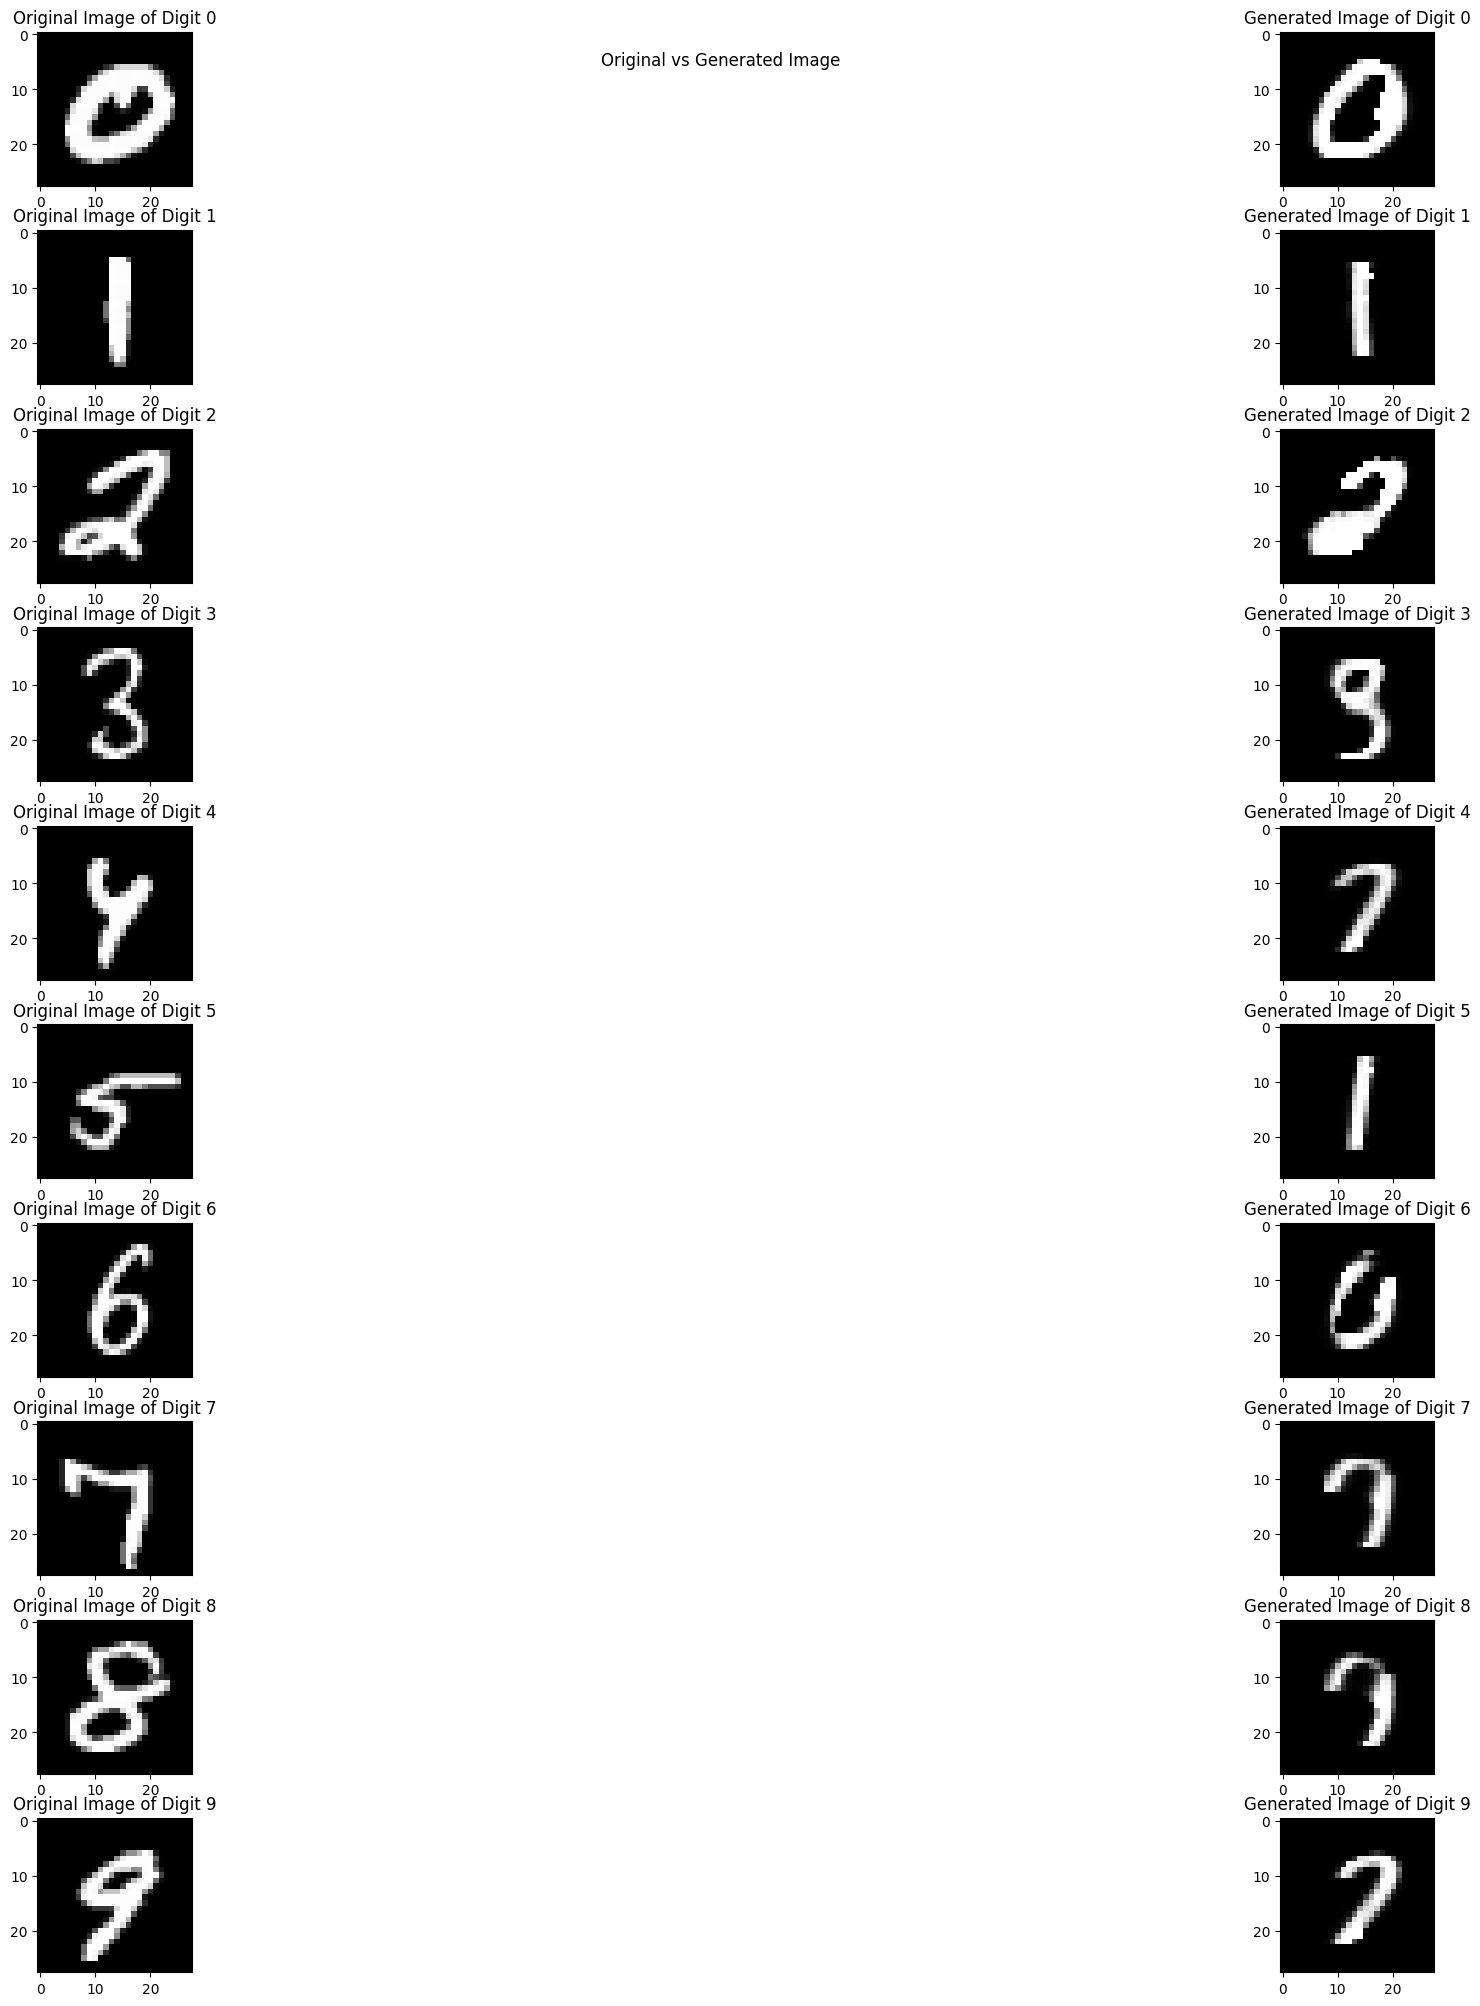

In [19]:
show_genreated_img(show_img,ssim_decoder,ssim_encoder)

# Question2

Plot the reconstruction loss and discriminator loss over all the epochs in one graph.
Comments on the nature/trend of the graphs produced.

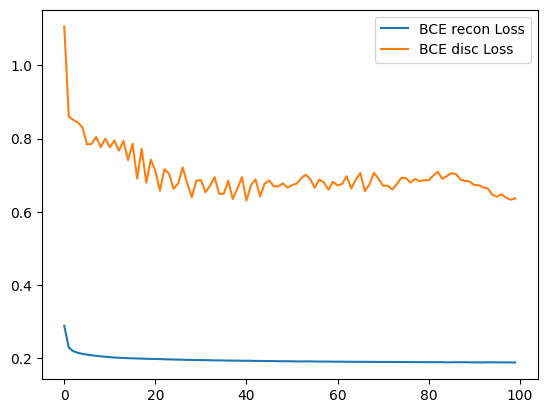

In [ ]:
plt.plot(range(0,100),bce_recon_loss)
plt.plot(range(0,100),bce_disc_loss)
plt.legend(["BCE recon Loss","BCE disc Loss"])
plt.show()

 note that in this graph the discrimator loss is continiously decreasing(initially at a greater rate and then at lower rate)

and the reconstruction loss is almost continiously decreasing

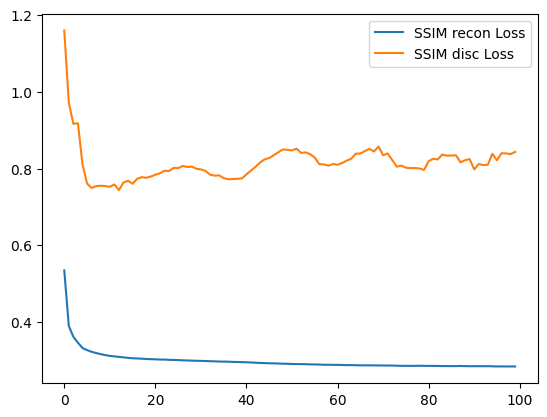

In [ ]:
plt.plot(range(0,100),ssim_recon_loss)
plt.plot(range(0,100),ssim_disc_loss)
plt.legend(["SSIM recon Loss","SSIM disc Loss"])
plt.show()

note here the descriminator loss is initially decreasing and then slowly starts increasing and then it becomes constant
this proves that the both encoder and discriminator are getting good at their assigned tasks from epoch to epoch

2) reconstruction loss is continiously decreasing

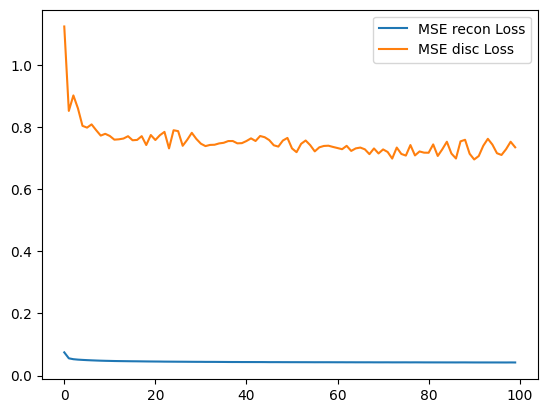

In [ ]:
plt.plot(range(0,100),mse_recon_loss)
plt.plot(range(0,100),mse_disc_loss)
plt.legend(["MSE recon Loss","MSE disc Loss"])
plt.show()

in this case the discriminator loss is showing a decreasing trend
and reconstruction loss is decreasing in the begining and remains constant

# Q3

### Write the entire training process of the vanilla adversarial autoencoder in brief and concise 3-5 step algorithm.


1)code a encoder network(having 3 layers in it and hidden layers having 1000 nodes in it) which takes the image as input and produces a output of dimensions=dimension of latent vector,code a decoder network(having 3 layers in it and hidden layers having 1000 nodes in it) whose input is the output of decoder and whose output size is same as that of the input for encoder,code a discriminator(haing 3 layers in it and hidden alyers having 500 nodes in it) whose input comes from encoder and whose task is to predict wether the image is real or fake

2) train decriminator in such a way that it can label the input recieved from pre defined distributions(here, normal distribution) as real and the input recieved from encoder as Fake

3) train "encoder-decoder" network in such a way that the output of the decoder is almost same as the input to the encoder

4) also using "encoder-descriminator" network train encoder in such a way that ,output vector from encoder looks like as if it has come from the predefined distribution(here,normal distribution)


# Q4

##Plot the  loss values for all the 3 loss functions as 2 separate plots

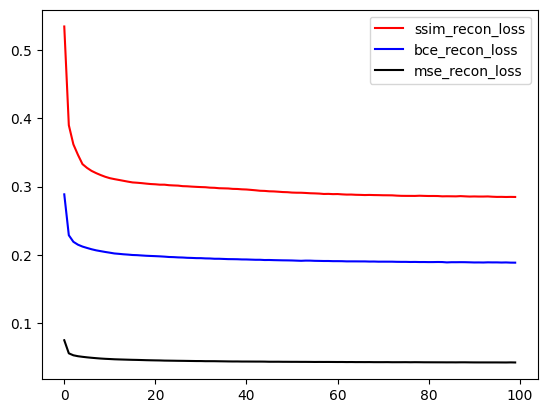

In [ ]:
plt.plot(range(0,100),ssim_recon_loss,color="red")
plt.plot(range(0,100),bce_recon_loss,color="blue")
plt.plot(range(0,100),mse_recon_loss,color="black")
plt.legend(["ssim_recon_loss","bce_recon_loss","mse_recon_loss"])
plt.show()

##
Q5. Based on the plots in Q4, provide your comments on which of the suggested loss functions is best for the current task and why

based on the above plot mse has got the the lower reconstruction loss and hence mse would be the best loss function for "encoder_decoder"(autoencoder) network